# Notebook summary
This notebook is used to extract skeleton data from the set of snatch lifts with EffNetV2.

Structure:
- Load libraries
- Get cluster settups
- Load data
- Load model
- Define utils function

Output:
- json annotation files for each sample
- zip file with pressed output

# Load libraries

In [ ]:
import torch
import os

from typing import Generator, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np

import cv2

from dataclasses import dataclass

import tensorflow as tf
import tensorflow_hub as hub

from google.colab import files

from tqdm.notebook import tqdm
import json

# Get cluster setup

In [ ]:
!nvidia-smi

Sat Nov 16 14:43:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.5 ; cuda:  cu121


In [ ]:
HOME = os.getcwd()
print(HOME)

/content


# Load data

In [ ]:
%cd {HOME}
!mkdir input
%cd {HOME}/input
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1UlKVja4PU0SvEqPy6xau3j2GqsZhJI3b' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1UlKVja4PU0SvEqPy6xau3j2GqsZhJI3b" -O sample-0.mp4 && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V6T-6x5maNxcaUKE9NKViIK-BmwlXgtg' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V6T-6x5maNxcaUKE9NKViIK-BmwlXgtg" -O sample-1.mp4 && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1d7qr0__8kJqs4wRGvUcmrQWMLXT_pCRO' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1d7qr0__8kJqs4wRGvUcmrQWMLXT_pCRO" -O sample-2.mp4 && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1VdyawknXgEN6AWl0a6D-eDiFRoZ6OiYF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1VdyawknXgEN6AWl0a6D-eDiFRoZ6OiYF" -O sample-3.mp4 && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1qVzvGMmN7GiE8aBCR7UR23o7AB4BUH4C' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1qVzvGMmN7GiE8aBCR7UR23o7AB4BUH4C" -O sample-4.mp4 && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1KLpUj7bU9YzDJrXcQnZk5X0E89I4BRUY' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1KLpUj7bU9YzDJrXcQnZk5X0E89I4BRUY" -O sample-5.mp4 && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=18RIbfTLJ4NuOISBtZTlPMwgvIHI6ApDT' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=18RIbfTLJ4NuOISBtZTlPMwgvIHI6ApDT" -O sample-6.mp4 && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1EgVaDuGOR199zqMXXU4NfKwvmGwM0WKe' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1EgVaDuGOR199zqMXXU4NfKwvmGwM0WKe" -O sample-7.mp4 && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1yq1DEfVF51pw3hLhY83bb1VkDBtk2hNa' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1yq1DEfVF51pw3hLhY83bb1VkDBtk2hNa" -O sample-8.mp4 && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1MoOQDw45_j3EnD4K3zUcHF_cSjvUIF7n' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1MoOQDw45_j3EnD4K3zUcHF_cSjvUIF7n" -O sample-9.mp4 && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1oqrl_y4JSfA1oO7IXIb9WObU4lMFaThY' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1oqrl_y4JSfA1oO7IXIb9WObU4lMFaThY" -O sample-10.mp4 && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1LNqpK9HfgSFFg1CO7yDY7d_IKmpgUGAD' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1LNqpK9HfgSFFg1CO7yDY7d_IKmpgUGAD" -O sample-11.mp4 && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1JP2np7osXUjCIzAydIjuWYQHfo4zSaXH' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1JP2np7osXUjCIzAydIjuWYQHfo4zSaXH" -O sample-12.mp4 && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=16HADx8kKoyhfqjmO6mFFqMbOcVCjQkTC' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=16HADx8kKoyhfqjmO6mFFqMbOcVCjQkTC" -O sample-13.mp4 && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1AbY6H4wlKQ5k-iyAbOWWj6tXDcLR3qEH' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1AbY6H4wlKQ5k-iyAbOWWj6tXDcLR3qEH" -O sample-14.mp4 && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1mlK8ldQKl8bOoQ_j9MuhscKt29FMgzKX' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1mlK8ldQKl8bOoQ_j9MuhscKt29FMgzKX" -O sample-15.mp4 && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1LBzGBRZGQh0kDS0TMsTsmR550liEYajg' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1LBzGBRZGQh0kDS0TMsTsmR550liEYajg" -O sample-16.mp4 && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=19x328T1iJAvJucVxQyOGiukUBTAIMbQP' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=19x328T1iJAvJucVxQyOGiukUBTAIMbQP" -O sample-17.mp4 && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1HPQyt2kt7zoHZ8Q8n-B8WuZUUtbXHK7a' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1HPQyt2kt7zoHZ8Q8n-B8WuZUUtbXHK7a" -O sample-18.mp4 && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1tm7ZAp5amBN-3WLMGXmhfo7Mi7JaJ7oB' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1tm7ZAp5amBN-3WLMGXmhfo7Mi7JaJ7oB" -O sample-19.mp4 && rm -rf /tmp/cookies.txt


/content
/content/input
--2024-11-16 14:43:50--  https://docs.google.com/uc?export=download&confirm=&id=1UlKVja4PU0SvEqPy6xau3j2GqsZhJI3b
Resolving docs.google.com (docs.google.com)... 142.250.157.102, 142.250.157.113, 142.250.157.138, ...
Connecting to docs.google.com (docs.google.com)|142.250.157.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1UlKVja4PU0SvEqPy6xau3j2GqsZhJI3b&export=download [following]
--2024-11-16 14:43:50--  https://drive.usercontent.google.com/download?id=1UlKVja4PU0SvEqPy6xau3j2GqsZhJI3b&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.157.132, 2404:6800:4008:c13::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.157.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 450728 (440K) [video/mp4]
Saving to: ‘sample-0.mp4’

sample-0.mp4        100%[===================>] 4

In [ ]:
SOURCE_VIDEO_0_PATH = f"{HOME}/input/sample-0.mp4"
SOURCE_VIDEO_1_PATH = f"{HOME}/input/sample-1.mp4"
SOURCE_VIDEO_2_PATH = f"{HOME}/input/sample-2.mp4"
SOURCE_VIDEO_3_PATH = f"{HOME}/input/sample-3.mp4"
SOURCE_VIDEO_4_PATH = f"{HOME}/input/sample-4.mp4"
SOURCE_VIDEO_5_PATH = f"{HOME}/input/sample-5.mp4"
SOURCE_VIDEO_6_PATH = f"{HOME}/input/sample-6.mp4"
SOURCE_VIDEO_7_PATH = f"{HOME}/input/sample-7.mp4"
SOURCE_VIDEO_8_PATH = f"{HOME}/input/sample-8.mp4"
SOURCE_VIDEO_9_PATH = f"{HOME}/input/sample-9.mp4"
SOURCE_VIDEO_10_PATH = f"{HOME}/input/sample-10.mp4"
SOURCE_VIDEO_11_PATH = f"{HOME}/input/sample-11.mp4"
SOURCE_VIDEO_12_PATH = f"{HOME}/input/sample-12.mp4"
SOURCE_VIDEO_13_PATH = f"{HOME}/input/sample-13.mp4"
SOURCE_VIDEO_14_PATH = f"{HOME}/input/sample-14.mp4"
SOURCE_VIDEO_15_PATH = f"{HOME}/input/sample-15.mp4"
SOURCE_VIDEO_16_PATH = f"{HOME}/input/sample-16.mp4"
SOURCE_VIDEO_17_PATH = f"{HOME}/input/sample-17.mp4"
SOURCE_VIDEO_18_PATH = f"{HOME}/input/sample-18.mp4"
SOURCE_VIDEO_19_PATH = f"{HOME}/input/sample-19.mp4"

# Load model

In [ ]:
model = hub.load('https://bit.ly/metrabs_xl')  # Takes about 3 minutes

# Define utils function

In [ ]:
%matplotlib inline


def generate_frames(video_file: str) -> Generator[np.ndarray, None, None]:
    video = cv2.VideoCapture(video_file)

    while video.isOpened():
        success, frame = video.read()

        if not success:
            break

        yield frame

    video.release()


def plot_image(image: np.ndarray, size: int = 12) -> None:
    plt.figure(figsize=(size, size))
    plt.axis('off')
    plt.imshow(image[...,::-1])
    plt.show()

In [ ]:
@dataclass(frozen=True)
class Point:
    x: float
    y: float

    @property
    def int_xy_tuple(self) -> Tuple[int, int]:
        return int(self.x), int(self.y)


@dataclass(frozen=True)
class Rect:
    x: float
    y: float
    width: float
    height: float

    @property
    def top_left(self) -> Point:
        return Point(x=self.x, y=self.y)

    @property
    def bottom_right(self) -> Point:
        return Point(x=self.x + self.width, y=self.y + self.height)

    @property
    def bottom_center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y + self.height)

@dataclass
class Detection:
    rect: Rect
    class_id: int
    confidence: float
    tracker_id: Optional[int] = None


@dataclass(frozen=True)
class Color:
    r: int
    g: int
    b: int

    @property
    def bgr_tuple(self) -> Tuple[int, int, int]:
        return self.b, self.g, self.r

In [ ]:
def draw_rect(image: np.ndarray, rect: Rect, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.rectangle(image, rect.top_left.int_xy_tuple, rect.bottom_right.int_xy_tuple, color.bgr_tuple, thickness)
    return image

In [ ]:
@dataclass(frozen=True)
class VideoConfig:
    fps: float
    width: int
    height: int


# create cv2.VideoWriter object that we can use to save output video
def get_video_writer(target_video_path: str, video_config: VideoConfig) -> cv2.VideoWriter:
    video_target_dir = os.path.dirname(os.path.abspath(target_video_path))
    os.makedirs(video_target_dir, exist_ok=True)
    return cv2.VideoWriter(
        target_video_path,
        fourcc=cv2.VideoWriter_fourcc(*"mp4v"),
        fps=video_config.fps,
        frameSize=(video_config.width, video_config.height),
        isColor=True
    )


def get_frame_count(path: str) -> int:
    cap = cv2.VideoCapture(path)
    return int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

## Test data and utils

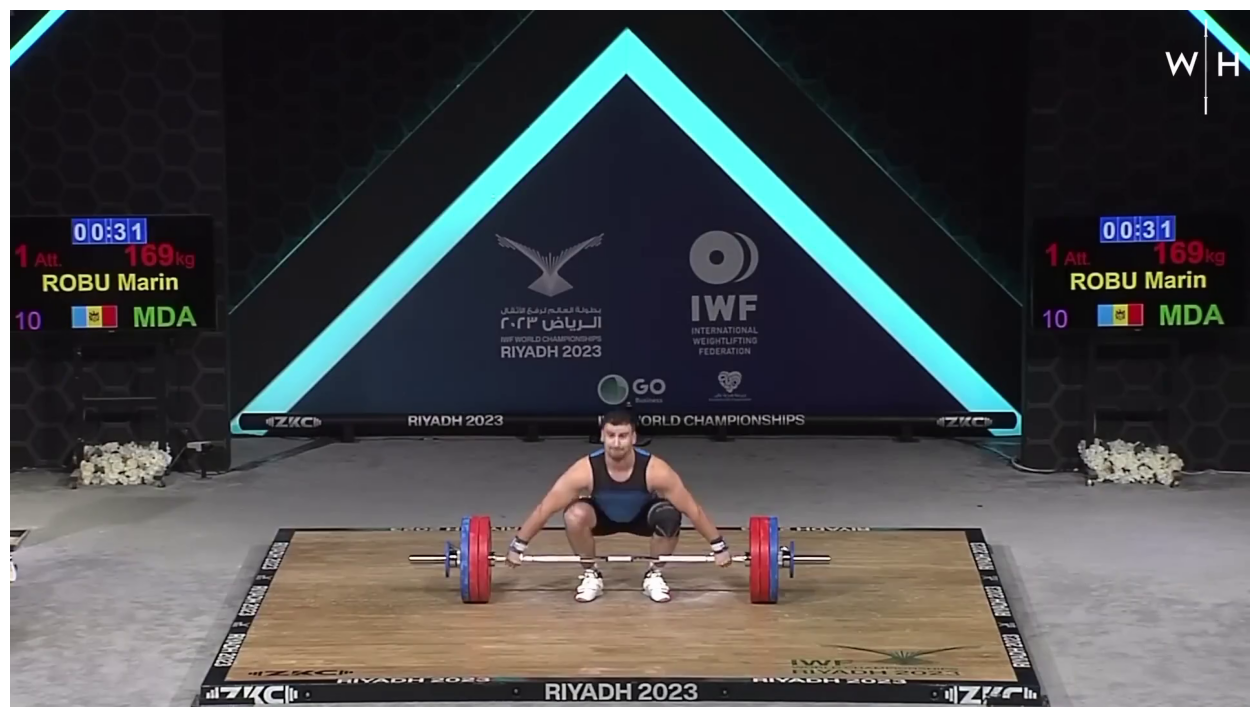

In [ ]:
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_16_PATH))

frame = next(frame_iterator)
plot_image(frame, 16)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data extraction

In [ ]:
directory_path = "/content/drive/MyDrive/master_thesis/input/mpi_inf_3dhp_17-annotations/"
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory created: {directory_path}")

for sample in list(range(20)):
    results_dictionary = {}
    SOURCE_VIDEO_PATH = f"/content/input/sample-{sample}.mp4"
    TARGET_VIDEO_PATH = f"{HOME}/output/output-sample-{sample}.mp4"
    file_path = f"/content/drive/MyDrive/master_thesis/input/mpi_inf_3dhp_17-annotations/sample-{sample}.json"

    cap = cv2.VideoCapture(SOURCE_VIDEO_PATH)

    video_config = VideoConfig(
      fps=25,
      width=int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
      height=int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    video_writer = get_video_writer(
      target_video_path=TARGET_VIDEO_PATH,
      video_config=video_config)

  # get fresh video frame generator
    frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH))

    total = get_frame_count(SOURCE_VIDEO_PATH)
    frame_number = 0

    for frame in tqdm(frame_iterator, total=total):
      annotated_frame = frame.copy()

      with torch.no_grad():
          results = model.detect_poses(frame, skeleton='mpi_inf_3dhp_17')
          # Convert EagerTensors to lists or NumPy arrays
          for key, value in results.items():
              if isinstance(value, type(tf.constant(0))):  # if value is an EagerTensor
                  results[key] = value.numpy().tolist() # convert to NumPy array and then to list
          results_dictionary[f'frame_{frame_number}'] = results
          frame_number += 1

    with open(file_path, "w") as file:
        json.dump(results_dictionary, file)

Directory created: /content/drive/MyDrive/master_thesis/input/mpi_inf_3dhp_17-annotations/


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

In [ ]:
joint_names = model.per_skeleton_joint_names['mpi_inf_3dhp_17'].numpy().astype(str).tolist()
joint_edges = model.per_skeleton_joint_edges['mpi_inf_3dhp_17'].numpy().tolist()

In [ ]:
joint_names

['htop',
 'neck',
 'rsho',
 'relb',
 'rwri',
 'lsho',
 'lelb',
 'lwri',
 'rhip',
 'rkne',
 'rank',
 'lhip',
 'lkne',
 'lank',
 'pelv',
 'spin',
 'head']

In [ ]:
joint_names_path = "/content/drive/MyDrive/master_thesis/input/mpi_inf_3dhp_17-annotations/joint_names.json"
joint_edges_path = "/content/drive/MyDrive/master_thesis/input/mpi_inf_3dhp_17-annotations/joint_edges.json"


with open(joint_names_path, "w") as file:
        json.dump(joint_names, file)

with open(joint_edges_path, "w") as file:
        json.dump(joint_edges, file)